### Building AutoEncoder in Keras on MNSIT datasat

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Conv2D, Input, Dense, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


In [8]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


#### Lets examine sample images

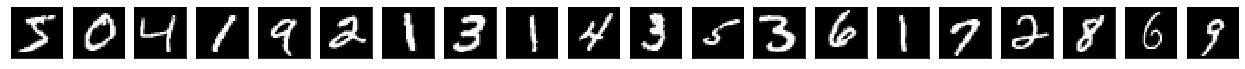

In [9]:
plt.figure(figsize=(22, 6))
for i in range(20):
  plt.subplot(1,20,i+1)
  plt.imshow(x_train[i],cmap='gray')
  plt.xticks([])
  plt.yticks([])
  
plt.show()

### Simple Autoencoder

In [10]:
input_dataset = Input(shape=(784,))
enc_fc_layer = Dense(32, activation = 'relu')
encoded = enc_fc_layer(input_dataset)

In [0]:
dec_fc_layer = Dense(784,activation = 'sigmoid')
decoded = dec_fc_layer(encoded)

In [12]:
autoencoder = Model(input_dataset,decoded)
autoencoder.compile(optimizer='adam',loss='binary_crossentropy')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:

def preprocessImage(img):
  img = img.astype('float32')/float(255)
  return img.reshape(-1, np.prod(img.shape[1:]))
  
x_train = preprocessImage(x_train)
x_test = preprocessImage(x_test)


# validation set for training
x_train, x_valid = train_test_split(x_train, test_size=500)

##### Let's train the autoencoder which compress the input image and restores to the original image size.

In [14]:
autoencoder.fit(x_train,x_train,epochs=100,batch_size=128,validation_data=(x_valid,x_valid))




Train on 59500 samples, validate on 500 samples
Epoch 1/100





59500/59500 [==============================] - 5s 84us/step - loss: 0.2292 - val_loss: 0.1620
Epoch 2/100
59500/59500 [==============================] - 4s 71us/step - loss: 0.1427 - val_loss: 0.1294
Epoch 3/100
59500/59500 [==============================] - 4s 73us/step - loss: 0.1203 - val_loss: 0.1145
Epoch 4/100
59500/59500 [==============================] - 4s 72us/step - loss: 0.1088 - val_loss: 0.1056
Epoch 5/100
59500/59500 [==============================] - 4s 75us/step - loss: 0.1021 - val_loss: 0.1005
Epoch 6/100
59500/59500 [==============================] - 4s 73us/step - loss: 0.0982 - val_loss: 0.0975
Epoch 7/100
59500/59500 [==============================] - 4s 72us/step - loss: 0.0962 - val_loss: 0.0962
Epoch 8/100
59500/59500 [==============================] - 5s 77us/step - loss: 0.0952 - val_loss: 0.0956
Epoch 9/100
59500/59500 [==============================] - 5s 78us/step - loss: 0.0946 - val_los

In [0]:
encoder = Model(input_dataset,encoded)
x_test_encoded = encoder.predict(x_test)

###### Lets confirm that 784 pixels are now compressed to 32 data points.

In [17]:
x_test_encoded[0].shape

(32,)

##### Now build decoder so that we can decode the encoded information into the original image size.

In [0]:
decoded_inputs = Input(shape=(32,))
decoder = Model(decoded_inputs,dec_fc_layer(decoded_inputs))

In [0]:
x_test_decoded = decoder.predict(x_test_encoded)

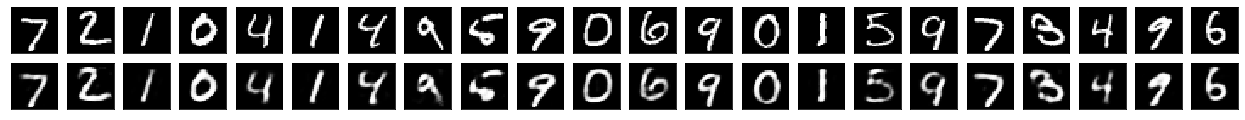

In [20]:
def show_decodedImages(before_image, after_image):
  plt.figure(figsize=(22,6))
  for i in range(22):
    plt.subplot(6,22,i+1)
    plt.imshow(before_image[i].reshape(28,28),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(6,22,22+i+1)
    plt.imshow(after_image[i].reshape(28,28),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    
    
show_decodedImages(x_test,x_test_decoded)

##### Can be deduced from above that decoded images could'nt restore completely original images.

## Convolutional AutoEncoder

In [0]:
def convolutional_autoencoder():
  inputs = Input(shape=(28, 28, 1))
  model = Conv2D(16,3,activation='relu',padding='same')(inputs)
  model = MaxPooling2D(padding='same')(model)
  model = Conv2D(8,3,activation='relu',padding='same')(model)
  model = MaxPooling2D(padding='same')(model)
  model = Conv2D(8,3,activation='relu',padding='same')(model)
  encoded_input_dataset = MaxPooling2D(padding='same')(model)
  
  model = Conv2D(8,3,activation='relu',padding='same')(encoded_input_dataset)
  model = UpSampling2D()(model)
  model = Conv2D( 8, 3, activation='relu', padding='same')(model)
  model = UpSampling2D()(model)
  model = Conv2D(16, 3, activation='relu')(model)
  model = UpSampling2D()(model)
  decoded_ = Conv2D(1, 3, activation='sigmoid', padding='same')(model)
                                       
  autoencoder = Model(inputs,decoded_)                                     
  autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
                                       
  return autoencoder

In [24]:
autoencoder = convolutional_autoencoder()
autoencoder.summary()


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 8)           0  

In [25]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)


autoencoder.fit(x_train,x_train,epochs = 50, batch_size = 128, validation_data=(x_valid,x_valid))


Train on 59500 samples, validate on 500 samples
Epoch 1/50
59500/59500 [==============================] - 81s 1ms/step - loss: 0.2133 - val_loss: 0.1450
Epoch 2/50
59500/59500 [==============================] - 81s 1ms/step - loss: 0.1328 - val_loss: 0.1265
Epoch 3/50
59500/59500 [==============================] - 83s 1ms/step - loss: 0.1211 - val_loss: 0.1191
Epoch 4/50
59500/59500 [==============================] - 83s 1ms/step - loss: 0.1149 - val_loss: 0.1141
Epoch 5/50
59500/59500 [==============================] - 84s 1ms/step - loss: 0.1108 - val_loss: 0.1100
Epoch 6/50
59500/59500 [==============================] - 84s 1ms/step - loss: 0.1078 - val_loss: 0.1076
Epoch 7/50
59500/59500 [==============================] - 83s 1ms/step - loss: 0.1054 - val_loss: 0.1051
Epoch 8/50
59500/59500 [==============================] - 84s 1ms/step - loss: 0.1035 - val_loss: 0.1036
Epoch 9/50
59500/59500 [==============================] - 83s 1ms/step - loss: 0.1019 - val_loss: 0.1020
Epoch 1

###### To see the quality of compression as well as decompression, let's just feed forward test images to see how the restored digits looks like.


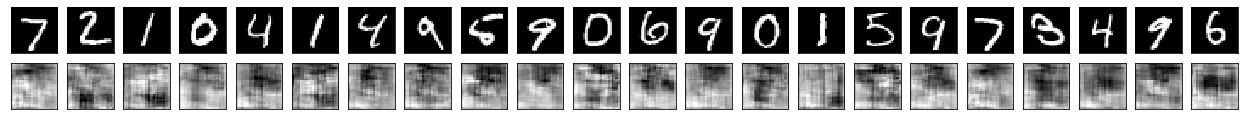

In [28]:
x_test_decoded_images = autoencoder.predict(x_test)

show_decodedImages(x_test, x_test_decoded_images)

### Noise Reduction by AutoEncoder

###### Let's add some random noise in the input MNSIT images and then use them as input for training. 

In [0]:
def add_random_noise(model, noise_factor = 0.3):
  model = model + np.random.randn(*model.shape)*noise_factor
  model = model.clip(0., .1)
  return model


In [0]:
#Noisy DataSet
x_train_noisy = add_random_noise(x_train)
x_test_noisy = add_random_noise(x_test)
x_valid_noisy = add_random_noise(x_valid)

##### We train a new autoencoder with noisy data as input and original data as expected output.

In [32]:
autoencoder = convolutional_autoencoder()
autoencoder.fit(x_train_noisy, x_train, epochs = 50, batch_size = 128, validation_data = (x_valid_noisy, x_valid))

Train on 59500 samples, validate on 500 samples
Epoch 1/50
59500/59500 [==============================] - 83s 1ms/step - loss: 0.2883 - val_loss: 0.2385
Epoch 2/50
59500/59500 [==============================] - 82s 1ms/step - loss: 0.1974 - val_loss: 0.1782
Epoch 3/50
59500/59500 [==============================] - 81s 1ms/step - loss: 0.1703 - val_loss: 0.1653
Epoch 4/50
59500/59500 [==============================] - 81s 1ms/step - loss: 0.1602 - val_loss: 0.1574
Epoch 5/50
59500/59500 [==============================] - 82s 1ms/step - loss: 0.1533 - val_loss: 0.1517
Epoch 6/50
59500/59500 [==============================] - 81s 1ms/step - loss: 0.1485 - val_loss: 0.1474
Epoch 7/50
59500/59500 [==============================] - 82s 1ms/step - loss: 0.1452 - val_loss: 0.1444
Epoch 8/50
59500/59500 [==============================] - 82s 1ms/step - loss: 0.1429 - val_loss: 0.1426
Epoch 9/50
59500/59500 [==============================] - 82s 1ms/step - loss: 0.1411 - val_loss: 0.1407
Epoch 1

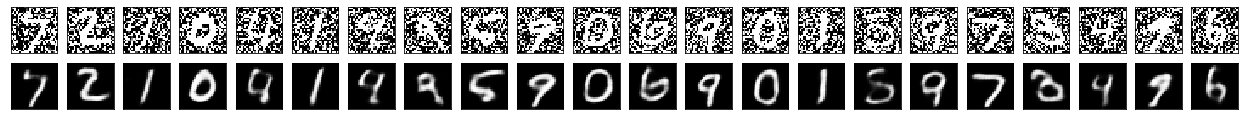

In [33]:
x_test_decoded = autoencoder.predict(x_test_noisy)
show_decodedImages(x_test_noisy,x_test_decoded)